## dependency

In [7]:
!pip install ConfigSpace

Mounted at /content/drive/


## random search

In [8]:
import ConfigSpace
import numpy as np
import typing


class RandomSearch(object):

    def __init__(self, config_space: ConfigSpace.ConfigurationSpace):
        self.config_space = config_space

    def initialize(self, capital_phi: typing.List[typing.Tuple[typing.Dict, float]]) -> None:
        pass

    def select_configuration(self) -> ConfigSpace.Configuration:
        return self.config_space.sample_configuration(size=None)

    def update_runs(self, run: typing.Tuple[typing.Dict, float]):
        pass


## surrogate model

In [9]:
import ConfigSpace

import pandas as pd
import sklearn.impute
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr


class SurrogateModel:

    def __init__(self, config_space):
        self.config_space = config_space
        self.df = None
        self.model = None

    def fit(self, df):
        """
        Receives a data frame, in which each column (except for the last two) represents a hyperparameter, the
        penultimate column represents the anchor size, and the final column represents the performance.

        :param df: the dataframe with performances
        :return: Does not return anything, but stores the trained model in self.model
        """
        self.df = df
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Identify categorical and numerical columns
        categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_features = X.select_dtypes(include=['number']).columns.tolist()

        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        # Create the ColumnTransformer to apply the appropriate transformations to each column
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        self.model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=1000, random_state=40))
        ])
        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        corr, _ = spearmanr(y_test, y_pred)
        print(f"External surrogate Model Evaluation: - MSE: {mse:.4f}, R2: {r2:.4f}")
        print(f"Spearman Correlation: {corr:.4f}")

    def predict(self, theta_new):
        """
        Predicts the performance of a given configuration theta_new

        :param theta_new: a dict, where each key represents the hyperparameter (or anchor)
        :return: float, the predicted performance of theta new (which can be considered the ground truth)
        """
        config_space = dict(self.config_space)
        for config in config_space:
            if config not in theta_new:
                theta_new[config] = config_space[config].default_value

        theta_new_df = pd.DataFrame([theta_new])
        X_test = theta_new_df[self.df.keys()[:-1]]
        return float(self.model.predict(X_test)[0])


## smbo

In [10]:
import ConfigSpace
import numpy as np
import pandas as pd
import typing

from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import norm
import scipy.stats as sps

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


class SequentialModelBasedOptimization(object):

    def __init__(self, config_space):
        """
        Initializes empty variables for the model, the list of runs (capital R), and the incumbent
        (theta_inc being the best found hyperparameters, theta_inc_performance being the performance
        associated with it)
        """
        self.config_space = config_space
        self.model = None
        self.R = []
        self.theta_inc = None
        self.theta_inc_performance = None

    def initialize(self, capital_phi: typing.List[typing.Tuple[typing.Dict, float]]) -> None:
        """
        Initializes the model with a set of initial configurations, before it can make recommendations
        which configurations are in good regions. Note that we are minimising (lower values are preferred)

        :param capital_phi: a list of tuples, each tuple being a configuration and the performance (typically,
        error rate)
        """
        self.R = capital_phi

        for config, performance in capital_phi:
            if self.theta_inc is None or performance < self.theta_inc_performance:
                self.theta_inc = config
                self.theta_inc_performance = performance

        self.fit_model()

    def fit_model(self) -> None:
        """
        Fits the internal surrogate model on the complete run list.
        """
        # Rs = []
        # for (c, p) in self.R:
        #     c = pd.DataFrame([c])
        #     p = [p]
        #     p = pd.DataFrame(p, columns=['score'])
        #     R_ = pd.concat([c, p], axis=1)
        #     Rs.append(R_)
        # df = pd.concat(Rs, axis=0)
        # X = df.iloc[:, :-1]
        # y = df.iloc[:, -1]
        df = pd.concat([pd.DataFrame([config]).assign(score=performance) for config, performance in self.R], axis=0)
        X = df.iloc[:, :-1]
        y = df['score']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Identify categorical and numerical columns
        categorical_features = X.select_dtypes(include=['object']).columns
        numerical_features = X.select_dtypes(include=['number']).columns

        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder())
        ])
        # Create the ColumnTransformer to apply the appropriate transformations to each column
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        # GaussianProcessRegressor as internal surrogate model
        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
        self.model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GaussianProcessRegressor(kernel=kernel, alpha=1e-4,
                                                   normalize_y=True, random_state=40,
                                                   n_restarts_optimizer=30))
        ])
        self.model.fit(X_train, y_train)

        pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        print(f"Internal Surrogate Model Evaluation: - MSE: {mse:.4f}, R2: {r2:.4f}")

        self.theta_inc = X.iloc[np.argmin(y)]
        self.theta_inc_performance = y.iloc[np.argmin(y)]

    def select_configuration(self) -> ConfigSpace.Configuration:
        """
        Determines which configurations are good, based on the internal surrogate model.
        Note that we are minimizing the error, but the expected improvement takes into account that.
        Therefore, we are maximizing expected improvement here.

        :return: A size n vector, same size as each element representing the EI of a given
        configuration
        """
        num_candidates = 200
        config_space = list(self.config_space.values())
        random_configs = [dict(self.config_space.sample_configuration()) for _ in range(num_candidates)]
        for configs in random_configs:
            for config in config_space:
                if config.name not in configs.keys():
                    configs[config.name] = config.default_value

        configs_df = pd.DataFrame(random_configs)
        e = self.expected_improvement(self.model, self.theta_inc_performance, configs_df)
        best_index  = np.argmax(e)
        return random_configs[best_index]

    @staticmethod
    def expected_improvement(model_pipeline: Pipeline, f_star: float, theta: np.array) -> np.array:
        """
        Acquisition function that determines which configurations are good and which
        are not good.

        :param model_pipeline: The internal surrogate model (should be fitted already)
        :param f_star: The current incumbent (theta_inc)
        :param theta: A (n, m) array, each column represents a hyperparameter and each row
        represents a configuration
        :return: A size n vector, same size as each element representing the EI of a given
        configuration
        """
        mu, sigma = model_pipeline.predict(theta, return_std=True)
        improvement = f_star - mu

        with np.errstate(divide='warn'):
            z = np.where(sigma > 0, improvement / sigma, 0)
            ei = improvement * norm.cdf(z) + sigma * norm.pdf(z)
            ei[sigma == 0.0] = 0.0

        return ei.ravel()

    def update_runs(self, run: typing.Tuple[typing.Dict, float]):
        """
        After a configuration has been selected and ran, it will be added to the run list
        (so that the model can be trained on it during the next iterations).

        :param run: A tuple (configuration, performance) where performance is error rate
        """
        config, performance = run
        self.R.append(run)

        if performance < self.theta_inc_performance:
            self.theta_inc = config
            self.theta_inc_performance = performance

        self.fit_model()


## successive halving

In [11]:
import ConfigSpace
import numpy as np
import pandas as pd

class SuccessiveHalving(object):
    def __init__(self, config_space: ConfigSpace.ConfigurationSpace, max_anchor_size, halving_factor: int = 2):
        self.config_space = config_space
        self.halving_factor = halving_factor
        self.max_anchor_size = max_anchor_size
        self.best_performance = []
        self.best = np.inf
        self.total_anchor = [0]

    def run(self, surrogate_model):
        total_performance = {}
        # anchor size to be 10% of data
        current_anchor = 25
        configs = [dict(self.config_space.sample_configuration()) for _ in range(64)]
        while(current_anchor<=self.max_anchor_size):
            self.total_anchor.append(current_anchor)
            performances = []
            m = len(configs)

            for config in configs:
                for hp in list(self.config_space.values()):
                    if hp.name not in config.keys():
                        config[hp.name] = hp.default_value
                config['anchor_size'] = current_anchor

                performance = surrogate_model.predict(config)
                performances.append(performance)

            total_performance['M'+str(current_anchor)] = performances
            performances = np.array(performances)
            performances_sorted = np.argsort(performances)
            num = int(m/self.halving_factor)

            configs = [configs[index] for index in performances_sorted[:num]]
            current_anchor *= self.halving_factor

        p = total_performance.get(list(total_performance.keys())[-1])[0]
        if p < self.best:
            self.best = p
            self.best_performance.append(total_performance)
        return self.best

## experiment

External surrogate Model Evaluation: - MSE: 0.0003, R2: 0.9944
Spearman Correlation: 0.9967
External surrogate Model Evaluation: - MSE: 0.0006, R2: 0.9895
Spearman Correlation: 0.9960
External surrogate Model Evaluation: - MSE: 0.0005, R2: 0.9908
Spearman Correlation: 0.9965
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.5979
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.6287
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.3869
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.5890
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.2836
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.5781
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.5240
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.4309
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.5540
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.4543
Internal Surrogate Model Evaluation: - MSE: 0.0001, R2: 0.5165
Internal Surrogate Model Evalua

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Internal Surrogate Model Evaluation: - MSE: 0.0026, R2: 0.5992
Internal Surrogate Model Evaluation: - MSE: 0.0023, R2: 0.4271
Internal Surrogate Model Evaluation: - MSE: 0.0021, R2: 0.6840
Internal Surrogate Model Evaluation: - MSE: 0.0022, R2: 0.5723
Internal Surrogate Model Evaluation: - MSE: 0.0020, R2: 0.7034
Internal Surrogate Model Evaluation: - MSE: 0.0023, R2: 0.6200
Internal Surrogate Model Evaluation: - MSE: 0.0022, R2: 0.6226
Internal Surrogate Model Evaluation: - MSE: 0.0034, R2: 0.5206
Internal Surrogate Model Evaluation: - MSE: 0.0022, R2: 0.6880
Internal Surrogate Model Evaluation: - MSE: 0.0026, R2: 0.5905
Internal Surrogate Model Evaluation: - MSE: 0.0031, R2: 0.4811
Internal Surrogate Model Evaluation: - MSE: 0.0022, R2: 0.4718
Internal Surrogate Model Evaluation: - MSE: 0.0019, R2: 0.5640
Internal Surrogate Model Evaluation: - MSE: 0.0027, R2: 0.5775
Internal Surrogate Model Evaluation: - MSE: 0.0018, R2: 0.6703
Internal Surrogate Model Evaluation: - MSE: 0.0023, R2:

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Internal Surrogate Model Evaluation: - MSE: 0.0021, R2: 0.6522
Internal Surrogate Model Evaluation: - MSE: 0.0016, R2: 0.6213
Internal Surrogate Model Evaluation: - MSE: 0.0021, R2: 0.6452
Internal Surrogate Model Evaluation: - MSE: 0.0016, R2: 0.7671
Internal Surrogate Model Evaluation: - MSE: 0.0020, R2: 0.6785
Internal Surrogate Model Evaluation: - MSE: 0.0014, R2: 0.6076
Internal Surrogate Model Evaluation: - MSE: 0.0022, R2: 0.5413
Internal Surrogate Model Evaluation: - MSE: 0.0013, R2: 0.7591


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Internal Surrogate Model Evaluation: - MSE: 0.0031, R2: 0.4079
Internal Surrogate Model Evaluation: - MSE: 0.0019, R2: 0.6971
Internal Surrogate Model Evaluation: - MSE: 0.0031, R2: 0.5209
Internal Surrogate Model Evaluation: - MSE: 0.0016, R2: 0.6766
Internal Surrogate Model Evaluation: - MSE: 0.0021, R2: 0.6696
External surrogate Model Evaluation: - MSE: 0.0000, R2: 0.9997
Spearman Correlation: 0.9998
External surrogate Model Evaluation: - MSE: 0.0000, R2: 0.9997
Spearman Correlation: 0.9998
External surrogate Model Evaluation: - MSE: 0.0000, R2: 0.9998
Spearman Correlation: 0.9998
Internal Surrogate Model Evaluation: - MSE: 0.0010, R2: 0.9227
Internal Surrogate Model Evaluation: - MSE: 0.0010, R2: 0.8856
Internal Surrogate Model Evaluation: - MSE: 0.0004, R2: 0.9653
Internal Surrogate Model Evaluation: - MSE: 0.0012, R2: 0.8521
Internal Surrogate Model Evaluation: - MSE: 0.0008, R2: 0.9073
Internal Surrogate Model Evaluation: - MSE: 0.0011, R2: 0.8938
Internal Surrogate Model Evalua

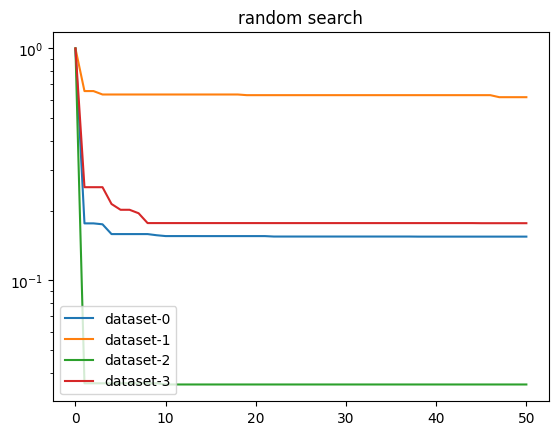

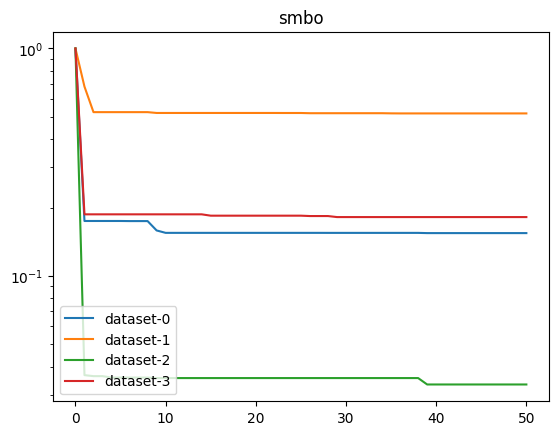

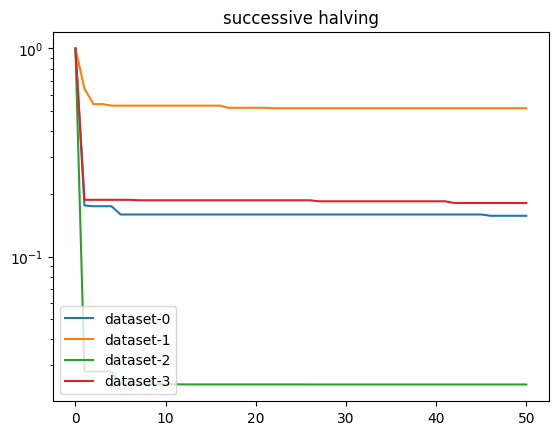

In [12]:
import argparse
import ConfigSpace
import matplotlib.pyplot as plt
import pandas as pd
# from random_search import RandomSearch
# from surrogate_model import SurrogateModel
# from smbo import SequentialModelBasedOptimization
# from successive_halving import SuccessiveHalving


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config_space_file', type=str, default='lcdb_config_space_knn.json')
    parser.add_argument('--configurations_performance_file', type=str, default='lcdb_configs.csv')
    # max_anchor_size: connected to the configurations_performance_file. The max value upon which anchors are sampled
    parser.add_argument('--max_anchor_size', type=int, default=1600)
    parser.add_argument('--num_iterations', type=int, default=50)

    args, _ = parser.parse_known_args()
    return args
    # return parser.parse_args()


def run(args):
    df = pd.read_csv(args.configurations_performance_file)
    config_space = ConfigSpace.ConfigurationSpace.from_json(args.config_space_file)
    random_search = RandomSearch(config_space)

    df_list = []
    df_1 = pd.read_csv(args.configurations_performance_file)
    df_2 = pd.read_csv('config_performances_dataset-1457.csv')
    df_3 = pd.read_csv('config_performances_dataset-11.csv')
    df_4 = pd.read_csv('config_performances_dataset-6.csv')
    df_list.append(df_1)
    df_list.append(df_2)
    df_list.append(df_3)
    df_list.append(df_4)

    plots = {
        'random search': [],
        'smbo': [],
        'successive halving': []
    }
    for df in df_list:
        smbo = SequentialModelBasedOptimization(config_space)
        sh = SuccessiveHalving(config_space,args.max_anchor_size,halving_factor=2)

        surrogate_model_rs = SurrogateModel(config_space)
        surrogate_model_smbo = SurrogateModel(config_space)
        surrogate_model_sh = SurrogateModel(config_space)
        surrogate_model_rs.fit(df)
        surrogate_model_smbo.fit(df)
        surrogate_model_sh.fit(df)

        configs = [dict(config_space.sample_configuration()) for _ in range(200)]
        for config in configs:
            config['anchor_size'] = args.max_anchor_size
            config['score'] = surrogate_model_smbo.predict(config)
        # configs_ = configs.copy()
        # for c in configs_:
        #     c = c.pop('anchor_size')
        # variables = list(df.keys())
        # variables.remove('anchor_size')
        # df_config = pd.DataFrame([[i[j] for j in variables] for i in configs_], columns=variables)
        # m, n = df_config.shape
        # initial_runs = []
        # for _, row in df_config.iterrows():
        #     config = dict(row.head(n-1))
        #     p = row['score']
        #     initial_runs.append((config, p))
        df_config = pd.DataFrame([{k: v for k, v in config.items() if k != 'anchor_size'} for config in configs])
        initial_runs = [(row.drop('score').to_dict(), row['score']) for _, row in df_config.iterrows()]
        smbo.initialize(initial_runs)

        results = {
            'random_search': [1.0],
            'smbo': [1.0],
            'successive_halving': [1.0]
        }

        for idx in range(args.num_iterations):
            theta_new_rs = dict(random_search.select_configuration())
            theta_new_rs['anchor_size'] = args.max_anchor_size
            performance_rs = surrogate_model_rs.predict(theta_new_rs)
            # ensure to only record improvements
            results['random_search'].append(min(results['random_search'][-1], performance_rs))
            random_search.update_runs((theta_new_rs, performance_rs))

            theta_new_smbo = dict(smbo.select_configuration())
            theta_new_smbo['anchor_size'] = args.max_anchor_size
            theta_new_smbo_update = theta_new_smbo.copy()
            performance_smbo = surrogate_model_smbo.predict(theta_new_smbo)
            results['smbo'].append(min(results['smbo'][-1], performance_smbo))
            del theta_new_smbo_update['anchor_size']
            smbo.update_runs((theta_new_smbo_update, performance_smbo))

            performance_sh = sh.run(surrogate_model_sh)
            results['successive_halving'].append(min(results['successive_halving'][-1], performance_sh))

        plots['random search'].append(results['random_search'])
        plots['smbo'].append(results['smbo'])
        plots['successive halving'].append(results['successive_halving'])

    for key, value in plots.items():
        for res in value:
          plt.plot(range(len(res)), res, label=f'dataset-{value.index(res)}')
        plt.legend()
        plt.yscale('log')
        plt.title(key)
        plt.show()


if __name__ == '__main__':
    run(parse_args())
